## Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np

from dataloader.load_fodf_simulated import load_fodf_simulated
from dataloader.load_dt_simulated import load_dt_simulated_dataset
from visualization.spherical_functions_visualisation import get_spherical_function_values_from_spherical_expansion

# Fibre orientation distribution function (fODF)

fODF can be interpreted as a probability density function of fibres going in a particular direction. Some researchers hold the view that diffusion orientation density function (dODF) should be the function of interest since it can be estimated via the ensemble average spin propagator which is a model-free approach and thus is also the most unbiased. However dODF is not equivalent to fODF (even though dODF is strongly infuenced by fODF) and only provides indirect information regarding the actual fibre orientations. Even when single coherent fibre population is present, dODF will still suggest a wide range of orientations centered around the actual orientation. On the other hand methods that estimate fODF directly often yield sharper and more accurate functions $^{[4,5]}$ see figure below.

![DODF_VS_FODF](./figures/dodf_vs_fodf.png)

Although the estimation of dODF is model-free it cannot be used as an fODF estimator without introducing a model and thus losing the main benefit of unbiasedness. And since this works focus is on mapping of brain connectivity and given that tractography algorithms require accurate estimates of fODFs it is sensible to estimate fODF directly from the MRI data.

"The advantage of representing fODF as a continuous function is that it possible to capture any complex fibre configuration (e.g. fibre curvature or fanning) as opposed to discrete represetations."(SD also uses straight fibres)

## fODF simulation

Ground truth data is essential for both model training and evaluation. However in the context of estimating fODF it is difficult to produce a real dataset since there is no physical measurement that is able to capture fODF. Nevertheless the algorithms can be validated on real data by comparing the algorithm predictions to regions with known structure e.g. corpus callosum.

Therefore an alternative approach is to simulate the fODF. The advantage of a synthetic dataset is that many aspects of the data can be fully controlled as opposed to real data. Simulated datasets are not limited by size and it is also possible to regenerate new datasets. With synthetic datasets the coverage of various values and the overall composition can be controlled. Finally synthetic data allow for noise robustness evaluation by validating the algorithm on datasets with varying noise intensity.

The simulation of single fODF comprises of several steps. At first $n$ fibre population directions are chosen by uniformly sampling the surface of unit sphere $n$ times yielding $n$ unit vectors. The random fibre directions $d_{f}$ are chosen as follows [2] (Eq 1):

$$
d_{f} = \frac{1}{\sqrt{x^{2} + y^{2} + z^{2}}}\begin{bmatrix}
x\\ 
y\\ 
z
\end{bmatrix}
$$

where $x$, $y$, $z$ are Gaussian random variables drawn from $\mathcal{N}(0,1)$. These random vectors are converted to spherical coordinates $(\theta, \phi)$ for further computations. Subsequently each $d_{f}$ is used to define a delta function on the surface of the sphere that is concentrated at the point $d_{f}$.

Delta function $\delta(x)$ is an impulse function that can be defined as any function in $\mathbb{R}$ that satisfies [1] (Eq 2):

$$
\int_{t_{-}}^{t_{+}}\delta(t-t_{0})f(t)dt = \begin{cases}
f(t_{0}), \, & t_{-} < t_{0} < t_{+} \\
0, \, & otherwise
\end{cases}
$$

and less rigorously as:

$$
\delta(x) = \begin{cases}
+\infty, \, & x =0 \\
0, \, & x \ne 0
\end{cases}
$$

Delta function satisfies the following properties:

$$
\int_{-\infty}^{\infty}\delta(x)dx=1,\; \int_{-\infty}^{\infty}f(x)\delta(x-a)dx=f(a)
$$

For the plot of delta function in $\mathbb{R}$ see below:

![DIRAC_DELTA_FUNCTION](./figures/dirac_delta_function.png)

Thus it is a natural choice for representing a direction. The concentration point of delta function can be translated from the origin to any point $a \in \mathbb{R}$ by taking $\delta(x-a)$.

The notion of the delta function can also be extended to spherical coordinates as follows:

$$
\delta(\overrightarrow{\mathbf{r}} - \overrightarrow{\mathbf{r}}_{0})= \frac{1}{sin\theta}\delta(\theta - \theta_0)\delta(\phi-\phi_0)
$$

where $\overrightarrow{\mathbf{r}}$ denotes vector of spherical coordinates $[\theta,\phi]^T$ and $\overrightarrow{\mathbf{r}}_{0}$ is the concentration point also in spherical coordinates resulting in a peak on the surface of the sphere pointing in the direction $(\theta,\phi)$. Now the spherical harmonics expansion (using the real and antipodal basis) is as follows:

$$
\frac{1}{sin\theta}\delta (\theta -\theta_{0}) \delta (\phi -\phi_{0}) = \sum_{l=0}^{\infty} \sum_{m=-l}^{l} Y^{m}_{l}(\theta_{0},\phi_{0}) Y^{m}_{l}(\theta,\phi)
$$

The infinite sum over $l$ shows that $\delta(\overrightarrow{\mathbf{r}} - \overrightarrow{\mathbf{r}}_{0})$ is not band-limited and thus during computation the series will need to be truncated at some degree resulting in imperfect approximation. The truncation degree is taken to be the maximum SH order predicted by a model. Finally the SH coefficients of all $n$ delta approximations are summed together to produce synthetic fODF.

The following code simulates fODF in a voxel containing three fibre populations aligned with the $x$, $y$ and $z$ axes where each population's volume fraction is $\frac{1}{3}$.

In [2]:
expansion_coefficients = load_fodf_simulated(max_degree=10)

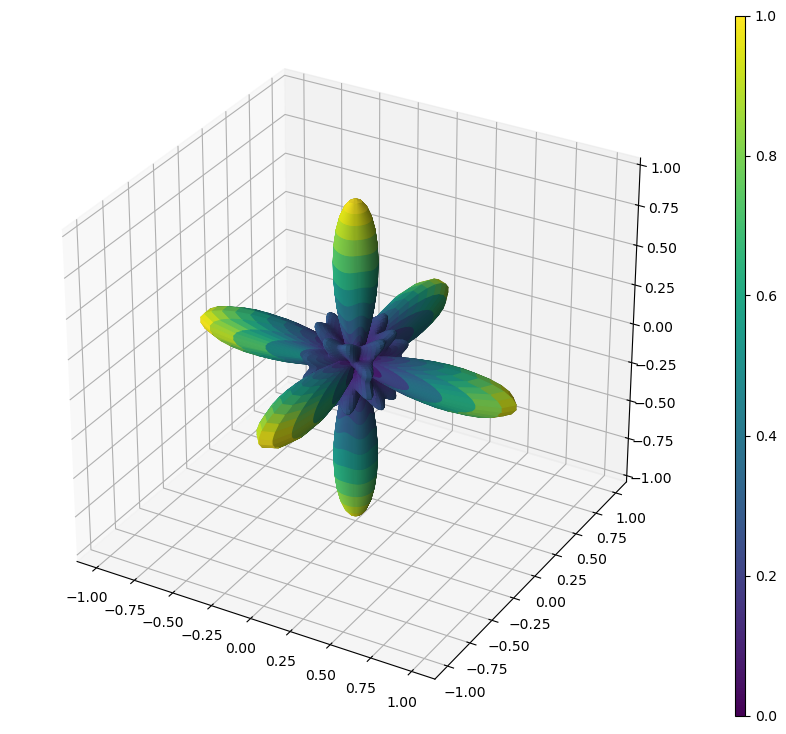

In [3]:
#%matplotlib qt

x, y, z, fcolors = get_spherical_function_values_from_spherical_expansion(expansion_coefficients=expansion_coefficients, max_degree=10, resolution=100, min_value=None, max_value=None)

x = x * fcolors
y = y * fcolors
z = z * fcolors

fig = plt.figure(figsize=(10,10))

cmap = plt.cm.viridis
normalization = Normalize(vmin=np.min(fcolors), vmax=np.max(fcolors))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=normalization)

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=plt.cm.viridis(fcolors), shade=True)
#ax.set_axis_off()
plt.gca().set_aspect('equal')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, ax=[ax], cax=cbar_ax)

plt.show()

In [4]:
data = load_dt_simulated_dataset(dataset_size=10, number_of_fibre_populations=2, max_degree=8, vary_gradients=False,seed=1)

## SH coefficients of fODF

In [5]:
data[0][0]

array([ 0.56418958, -0.13111685, -0.49073521, -0.44707529,  0.09583606,
       -0.159249  , -0.83508382, -0.22780671,  0.15410587,  0.68045109,
        0.09250214, -0.17404608, -0.02959044,  0.36561824, -0.41710338,
        0.57873551,  0.18721484, -0.07352978,  0.310719  , -0.14362039,
       -0.58305532,  0.29194454,  0.23467149,  0.17507124, -0.28907762,
        0.06058064, -1.07121197, -0.1378505 ,  0.55084023, -0.06422956,
        0.22126219, -0.08869361,  0.59056227, -0.32102134,  0.04997917,
        0.25256474, -0.55037854, -0.25178578, -0.21873382,  0.04435548,
        0.18274682,  0.80053304,  0.17736465, -0.04544185, -0.35735456])

## b-vals, gradients, signals

In [6]:
data[1][0]

(array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
        1000, 1000]),
 array([[ 0.36353657, -0.79057113, -0.61636162,  0.47329009, -0.82269029,
          0.89697745, -0.94988454, -0.16577181, -0.81933594, -0.8108305 ,
          0.87454161,  0.91075499, -0.29634718,  0.07737383, -0.0756303 ,
          0.18488546,  0.53113688, -0.67804166,  0.52939376, -0.0155802 ,
          0.0529998 , -0.9090384 ,  0.12865447,  0.19786134, -0.71456792,
          0.5073

## Fibre orientations

In [7]:
data[2][0]

array([[ 0.36353657,  0.86429949,  0.34760259],
       [-0.79057113,  0.54924163,  0.27079683]])

## References

[1] Kusse, B.R. and Westwig, E.A. (2006). The Dirac δ-Function. In Mathematical Physics (eds B.R. Kusse and E.A. Westwig). https://doi.org/10.1002/9783527618132.ch5

[2] Muller, M. E. "A Note on a Method for Generating Points Uniformly on N-Dimensional Spheres." Comm. Assoc. Comput. Mach. 2, 19-20, Apr. 1959.

## Figure references

https://en.wikipedia.org/wiki/Dirac_delta_function#/media/File:Dirac_distribution_PDF.svg